### Simulation

The previous files hold the symbolic equations of motion that we need to represent the system. Now, we must transform them into Python functions to be able to use in numerical integration. The main objective of the simulations is to analyze the kinematic performance of the system under 3 gravity conditions, i.e., earth's (9.81 m/s²), mars (3.711 m/s²) and moon (1.62 m/s²). 

In [1]:
# Loading previous solutions and importing needed libraries
from equations_of_motion_solution import *
from sympy.physics.vector import vlatex
from sympy import init_printing
from IPython.display import Image
init_printing(use_latex='mathjax', pretty_print=False)

In [2]:
# Import NumPy functions to setp the numerical values and integrate the equations of motion
from numpy import deg2rad, rad2deg, array, zeros, linspace

# Import System to integrate EOM using Kane's Method
from pydy.system import System

# Import PyDy's ODE function generation to generate the symbolic equations into numerical function
from pydy.codegen.ode_function_generators import generate_ode_function

# Import a few functions from Matplotlib.PyPlot
from matplotlib.pyplot import plot, legend, xlabel, ylabel, rcParams
%matplotlib inline

---
#### Variables
Now, we will need to gather the variables, in the equations of motions into lists, i.e. constants, coordinates, speeds and specific inputs.

#### Constants

There are 21 constants in the system:

In [3]:
constants = [lower_arm_length,
             lower_arm_com_length,
             lower_arm_mass,
             lower_arm_inertia,
             upper_arm_length,
             upper_arm_com_length,
             upper_arm_mass,
             upper_arm_inertia,
             hand_length,
             hand_com_length,
             hand_mass,            
             hand_inertia,
             finger1_length,
             finger1_com_length,
             finger1_mass,
             finger1_inertia,
             finger2_length,
             finger2_com_length,
             finger2_mass,
             finger2_inertia,           
             g]
constants

[l_L, d_L, m_L, I_Lz, l_U, d_U, m_U, I_Uz, l_H, d_H, m_H, I_Hz, l_F1, d_F1, m_F1, I_F1z, l_F2, d_F2, m_F2, I_F2z, g]

#### Time varying variables

The states are dependant of the coordinates and speeds. There are 16 varying specified inputs to the system

In [4]:
coordinates = [lambda1, lambda2, lambda3, lambda4, lambda5]

speeds = [omega1, omega2, omega3, omega4, omega5]

specifieds = [ground_joint_torque, lower_arm_joint_torque, upper_arm_joint_torque, finger1_joint_torque, finger2_joint_torque]

In [5]:
# Create the time domain as a numpy array with 60 points per second, for 3 seconds
import numpy as np
t = np.linspace(0,3,60*3)

#### Generating the ODE function

The ordinary differential equation integrator scipy.integrate.odeint require a function that numerically evaluates the right hand side of the coupled first order ordinary differential equations. In `mass_matrix` and `forcing_vector` are the symbolic form of the constants and variables. `odeint` function requires the right hand side function, the initial conditions and a time vector. 

In [6]:
# Passing the RHS to the ODE function generator
right_hand_side = generate_ode_function(forcing_vector, coordinates, speeds, constants, mass_matrix=mass_matrix, specifieds=specifieds)

# Setting the speeds and coordinates initial conditions 
x0 = {lambda1: np.deg2rad(-90),    # Lower arm horizontally oriented
      lambda2: np.deg2rad(0),
      lambda3: np.deg2rad(0),
      lambda4: np.deg2rad(15),
      lambda5: np.deg2rad(-15),
      omega1: 0.0,
      omega2: 0.0,
      omega3: 0.0,
      omega4: 0.0,
      omega5: 0.0}

Now, we need to specify the numerical value for all constants. To work with realistic values, a 3D CAD geometry was design to model the robot arm. The material of the 4 part robot arm is standard structural steel.

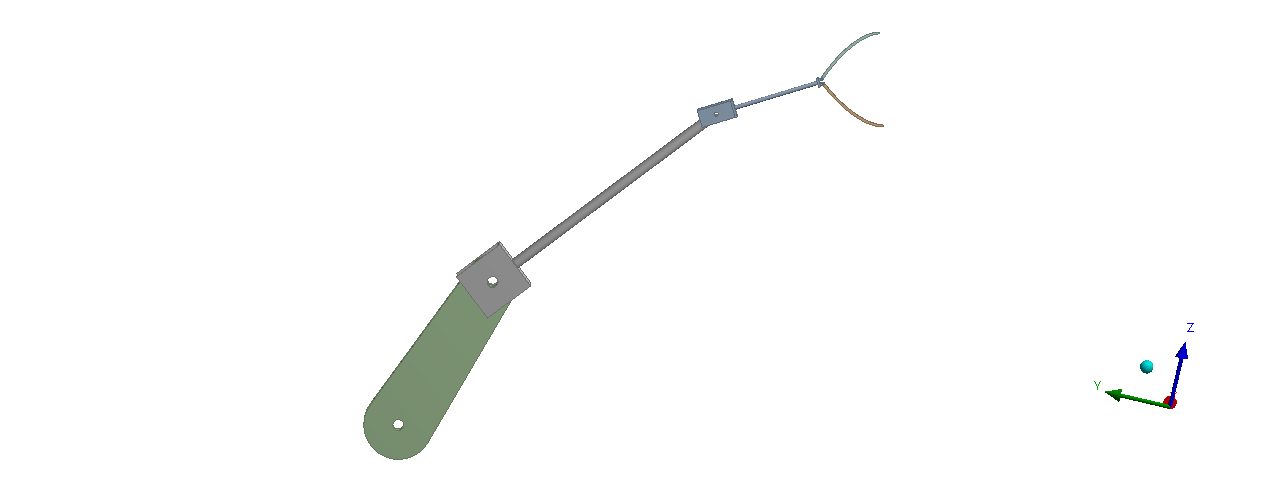

In [7]:
Image('https://user-images.githubusercontent.com/60149913/106359945-340cf380-62ec-11eb-8b14-1b2dfe42aa22.png', width=1032, height=400)

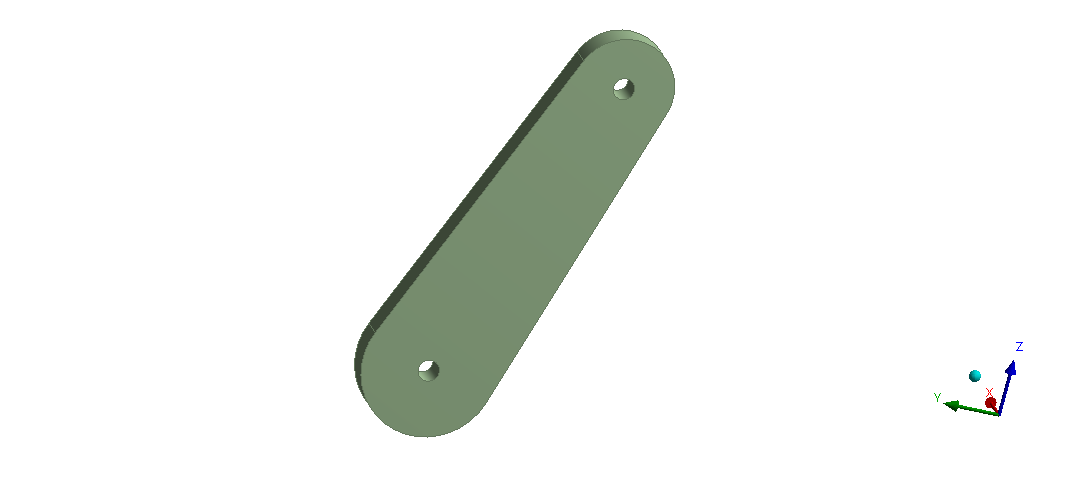

In [8]:
Image('https://user-images.githubusercontent.com/60149913/106360132-2e63dd80-62ed-11eb-8d96-7483cf61319d.png', width=332, height=150)

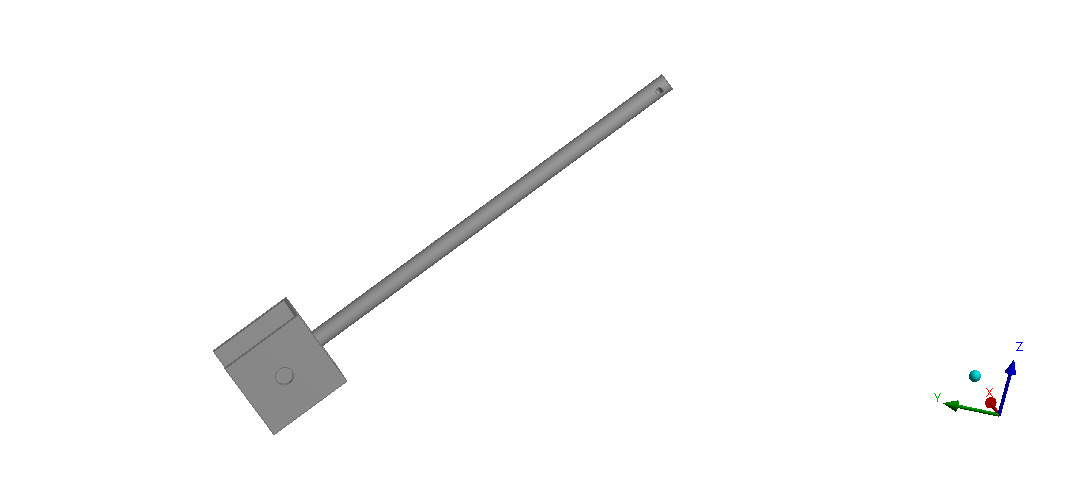

In [9]:
Image('https://user-images.githubusercontent.com/60149913/106360135-302da100-62ed-11eb-8fef-fde1e60e99a4.png', width=332, height=150)

In [10]:
Image('https://user-images.githubusercontent.com/60149913/106360139-315ece00-62ed-11eb-8c7f-9cdb1302a96c.png', width=332, height=150)

FileNotFoundError: No such file or directory: 'None'

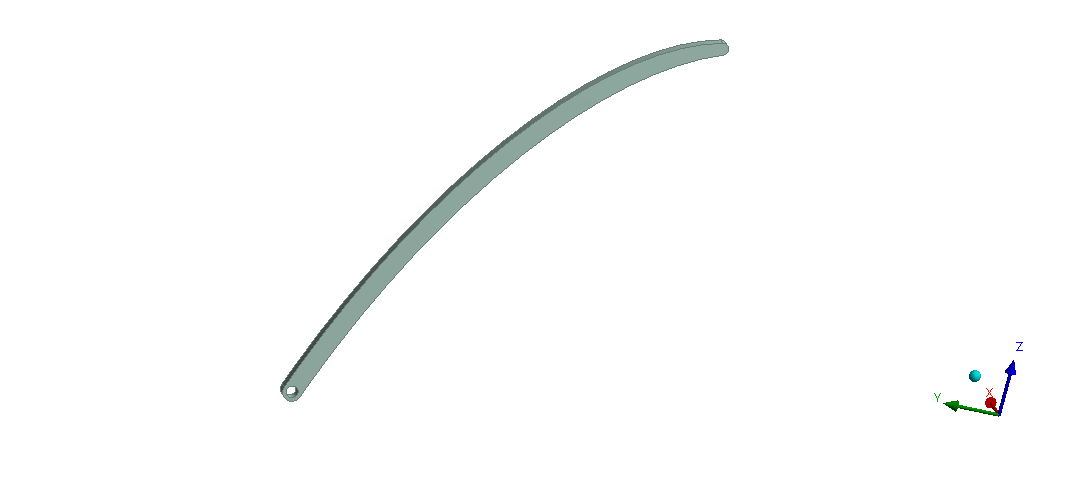

In [14]:
Image('https://user-images.githubusercontent.com/60149913/106360140-31f76480-62ed-11eb-9abe-3f68f702a072.png', width=332, height=150)

Although there are 21 constants in the system, only 19 values are needed to perform the numerical simulation. The fingers length are not used and the solver may raise an error.

In [25]:
numerical_constants = {lower_arm_length: 1.0,         # lower_arm_length [m]   
                       lower_arm_com_length: 0.44309, # lower_arm_com_length [m]
                       lower_arm_mass: 347.2,         # lower_arm_mass [kg]
                       lower_arm_inertia: 49.945,     # lower_arm_inertia [kg*m^2]
                       upper_arm_length: 1.62475,     # upper_arm_length [m]
                       upper_arm_com_length: 0.56774, # upper_arm_com_length [m]
                       upper_arm_mass: 61.10,         # upper_arm_mass [kg]
                       upper_arm_inertia: 18.80,      # upper_leg_inertia [kg*m^2]
                       hand_length: 0.6428,           # hand_length [m]
                       hand_com_length: 0.1424,       # hand_com_length [m]
                       hand_mass: 7.33,               # hand_mass [kg]
                       hand_inertia: 0.31035,         # hand_inertia [kg*m^2]
                       #finger1_length: 0.4218,       # finger1_length [m]          Doesn't matter/Not on the mass or forcing matrices
                       finger1_com_length: 0.2077,    # finger1_com_length [m]
                       finger1_mass: 0.5,             # finger1_mass [kg]
                       finger1_inertia: 0.007322,     # finger1_inertia [kg*m^2]
                       #finger2_length: 0.4218,       # finger2_length [m]           Doesn't matter/Not on the mass or forcing matrices
                       finger2_com_length: 0.2077,    # finger2_com_length [m]
                       finger2_mass: 0.5,             # finger2_mass [kg]
                       finger2_inertia: 0.007322,     # finger2_inertia [kg*m^2]
                       g: 9.81}                       # acceleration due to gravity [m/s^2]

Set the torques values as a lambda function and plot with respect to time. To plot the torques, create an array with the values.

In [22]:
# Specified torques functions
numerical_specifieds = [{ground_joint_torque: lambda lambda1, t: -1000*t**2+9000*np.ones(np.shape(t)),
                        lower_arm_joint_torque: lambda lambda2, t: -500*t**2+4500*np.ones(np.shape(t)),
                        upper_arm_joint_torque: lambda lambda3, t: -25*t**2+225*np.ones(np.shape(t)),
                        finger1_joint_torque: lambda lambda4, t: -10*t**2+90*np.ones(np.shape(t)),
                        finger2_joint_torque: lambda lambda5, t: -10*t**2+90*np.ones(np.shape(t))},

                        {ground_joint_torque: lambda lambda1, t: -378*t**2+3404*np.ones(np.shape(t)),
                        lower_arm_joint_torque: lambda lambda2, t: -190*t**2+1710*np.ones(np.shape(t)),
                        upper_arm_joint_torque: lambda lambda3, t: -9.5*t**2+85.5*np.ones(np.shape(t)),
                        finger1_joint_torque: lambda lambda4, t: -3.8*t**2+34.2*np.ones(np.shape(t)),
                        finger2_joint_torque: lambda lambda5, t: -3.8*t**2+34.2*np.ones(np.shape(t))},

                        {ground_joint_torque: lambda lambda1, t: -165*t**2+1485*np.ones(np.shape(t)),
                        lower_arm_joint_torque: lambda lambda2, t: -82.5*t**2+742.5*np.ones(np.shape(t)),
                        upper_arm_joint_torque: lambda lambda3, t: -4.125*t**2+37.125*np.ones(np.shape(t)),
                        finger1_joint_torque: lambda lambda4, t: -1.65*t**2+14.85*np.ones(np.shape(t)),
                        finger2_joint_torque: lambda lambda5, t: -1.65*t**2+14.85*np.ones(np.shape(t))}]

numerical_specified_plot = [[-1000*t**2+9000*np.ones(np.shape(t)),      # Only for the plot
                            -500*t**2+4500*np.ones(np.shape(t)),
                            -25*t**2+225*np.ones(np.shape(t)),
                            -10*t**2+90*np.ones(np.shape(t)),
                            -10*t**2+90*np.ones(np.shape(t))],
                            [-378*t**2+3404*np.ones(np.shape(t)),
                            -190*t**2+1710*np.ones(np.shape(t)),
                            -9.5*t**2+85.5*np.ones(np.shape(t)), 
                            -3.8*t**2+34.2*np.ones(np.shape(t)),
                            -3.8*t**2+34.2*np.ones(np.shape(t))],
                            [-165*t**2+1485*np.ones(np.shape(t)),
                            -82.5*t**2+742.5*np.ones(np.shape(t)),
                            -4.125*t**2+37.125*np.ones(np.shape(t)),
                            -1.65*t**2+14.85*np.ones(np.shape(t)),
                            -1.65*t**2+14.85*np.ones(np.shape(t))]]

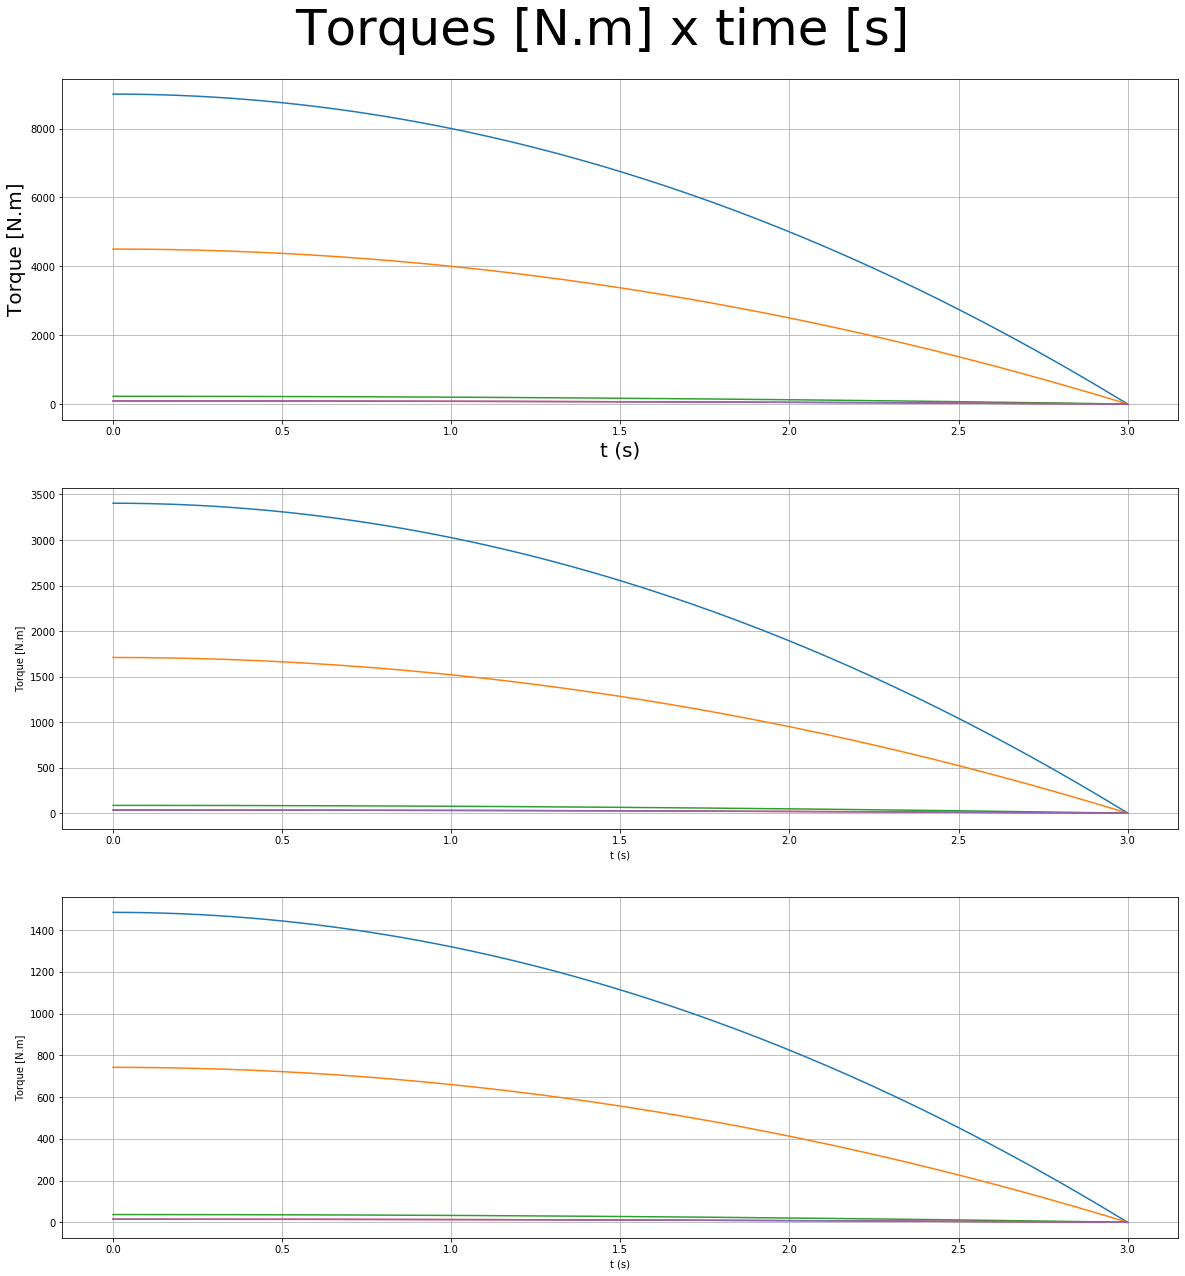

In [49]:
# Plot the torques function for each gravity value
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_figheight(20)
fig.set_figwidth(20)
fig.subplots_adjust(top=0.93)
fig.suptitle('Torques [N.m] x time [s]', fontsize=50)

ax1.plot(t, np.transpose(numerical_specified_plot[0]), label=['ground_joint_torque', 'lower_arm_joint_torque', 'upper_arm_joint_torque', 'finger1_joint_torque', 'finger2_joint_torque'])
ax1.set_xlabel('t (s)', fontsize=20)
ax1.set_ylabel('Torque [N.m]', fontsize=20)
ax1.grid()


ax2.plot(t, np.transpose(numerical_specified_plot[1]))
ax2.set_xlabel('t (s)')
ax2.set_ylabel('Torque [N.m]')
ax2.grid()

ax3.plot(t, np.transpose(numerical_specified_plot[2]))
ax3.set_xlabel('t (s)')
ax3.set_ylabel('Torque [N.m]')
ax3.grid()
plt.show()

Integrate the equations of motion for each gravity and torque value

Solve the initial value problem and simulate the motion. The shape of the solution vector is (5 generalized coordinates and its respective velocities)

In [38]:
# Integrating the system with the constants, specified and initial condition values
sys = System(kane,
             constants=numerical_constants,
             specifieds=numerical_specifieds,
             initial_conditions=x0,
             times=t)

y = sys.integrate()

Plot the results for the coordiantes and velocities

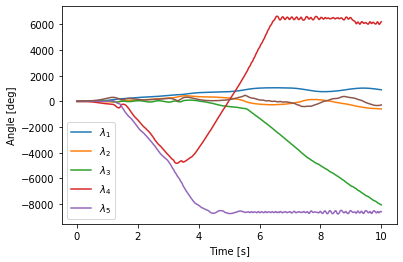

In [40]:
# Generalized coordinates
plot(t, rad2deg(y[:, :6]))
xlabel('Time [s]')
ylabel('Angle [deg]')
legend(["${}$".format(vlatex(c)) for c in coordinates])

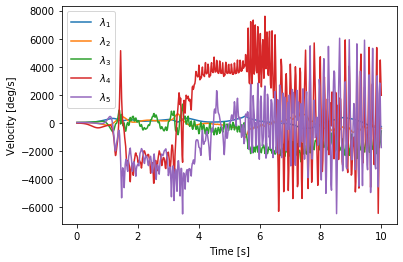

In [41]:
# Velocities
plot(t, rad2deg(y[:, 5:10]))
xlabel('Time [s]')
ylabel('Velocity [deg/s]')
legend(["${}$".format(vlatex(c)) for c in coordinates])